# Factorización de Matrices y Máquinas

- Sebastián Gacitúa
- Bastián Guzmán
- Jose Zamora
- Leandro Aroca
- Matthias Clein

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
import matplotlib.pyplot as plt

## Factorización de Matrices

In [222]:
dataset = pd.read_csv('../data/clicks_train.csv', sep = ',', nrows=10000)
dataset.head()

,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1
3,1,156824,0
4,1,279295,0


In [223]:
# Respaldo de los valores reales de los ID's
dataset["display_id_original"] = dataset["display_id"]
dataset["ad_id_original" ] = dataset["ad_id"]

In [224]:
dataset.display_id = dataset.display_id.astype('category').cat.codes.values #Convierte en valores numéricos categóricos
dataset.ad_id = dataset.ad_id.astype('category').cat.codes.values #Convierte en valores numéricos categóricos

In [225]:
dataset["ad_id"].value_counts()

2646    50
2113    50
4225    44
1134    43
2778    37
        ..
756      1
2705     1
3162     1
3615     1
2577     1
Name: ad_id, Length: 4319, dtype: int64

In [226]:
dataset["display_id"].value_counts()

918     12
543     12
914     10
1361    10
1701    10
        ..
599      2
1839     2
397      2
398      2
1007     2
Name: display_id, Length: 1959, dtype: int64

In [227]:
dataset.describe()

,display_id,ad_id,clicked,display_id_original,ad_id_original
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,986.437100,2207.364200,0.195900,987.437100,156850.550300
std,566.631537,1189.417955,0.396912,566.631537,83494.478172
min,0.000000,0.000000,0.000000,1.000000,1174.000000
25%,494.750000,1222.750000,0.000000,495.750000,92111.500000
50%,995.000000,2220.000000,0.000000,996.000000,153204.000000
75%,1478.250000,3198.000000,0.000000,1479.250000,211592.000000
max,1958.000000,4318.000000,1.000000,1959.000000,348149.000000


In [228]:
train, test = train_test_split(dataset, test_size=0.2)

In [229]:
n_displays, n_ads = len(dataset.display_id.unique()), len(dataset.ad_id.unique())
n_latent_factors = 20 #Número mínimo de calificaciones

In [230]:
print("displays",n_displays)
print("ads",n_ads)

displays 1959
ads 4319


In [231]:
ad_input = keras.layers.Input(shape=[1],name='Item')
ad_embedding = keras.layers.Embedding(n_ads + 1, n_latent_factors, name='ad-Embedding')(ad_input)
ad_vec = keras.layers.Flatten(name='Flatten-ad')(ad_embedding)

display_input = keras.layers.Input(shape=[1],name='User')
display_embedding = keras.layers.Embedding(n_displays + 1, n_latent_factors,name='display-Embedding')(display_input)
display_vec = keras.layers.Flatten(name='Flatten-display')(display_embedding)

prod = keras.layers.dot([ad_vec, display_vec], axes=1,name='DotProduct')
model = keras.Model([display_input, ad_input], prod)

In [232]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [233]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Item (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 User (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 ad-Embedding (Embedding)       (None, 1, 20)        86400       ['Item[0][0]']                   
                                                                                                  
 display-Embedding (Embedding)  (None, 1, 20)        39200       ['User[0][0]']                   
                                                                                            

In [234]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early = [EarlyStopping(monitor='loss', min_delta = 1e-4, patience = 20, verbose = 0,)]
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = "matrix_factorization_weights.hdf5",
                                   verbose = 1,
                                   monitor = "loss",
                                   save_best_only = True)
history = model.fit([train.display_id, train.ad_id], train.clicked, epochs=100, verbose=1, callbacks = [early, checkpoint])

Epoch 1/100
232/250 [==========================>...] - ETA: 0s - loss: 0.1968 - mae: 0.1992 - mse: 0.1968
Epoch 1: loss improved from inf to 0.19851, saving model to matrix_factorization_weights.hdf5
250/250 [==============================] - 1s 3ms/step - loss: 0.1985 - mae: 0.2008 - mse: 0.1985
Epoch 2/100
241/250 [===========================>..] - ETA: 0s - loss: 0.1939 - mae: 0.1977 - mse: 0.1939
Epoch 2: loss improved from 0.19851 to 0.19448, saving model to matrix_factorization_weights.hdf5
250/250 [==============================] - 1s 3ms/step - loss: 0.1945 - mae: 0.1984 - mse: 0.1945
Epoch 3/100
240/250 [===========================>..] - ETA: 0s - loss: 0.1875 - mae: 0.1958 - mse: 0.1875
Epoch 3: loss improved from 0.19448 to 0.18742, saving model to matrix_factorization_weights.hdf5
250/250 [==============================] - 1s 3ms/step - loss: 0.1874 - mae: 0.1958 - mse: 0.1874
Epoch 4/100
233/250 [==========================>...] - ETA: 0s - loss: 0.1747 - mae: 0.1917 - mse:

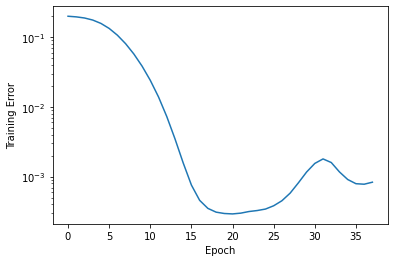

In [235]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.show()

In [236]:
model.load_weights("matrix_factorization_weights.hdf5")

In [237]:
results = model.evaluate((test.display_id, test.ad_id), test.clicked, batch_size = 1)

2000/2000 [==============================] - 2s 1ms/step - loss: 0.1979 - mae: 0.2362 - mse: 0.1979


In [238]:
ad_embedding_learnt = model.get_layer(name='ad-Embedding').get_weights()[0]

In [239]:
display_embedding_learnt = model.get_layer(name='display-Embedding').get_weights()[0]

In [240]:
def recommend(display_id, number_of_ads = 5): #Obtiene la lista de recomendaciones codificada 
    ads = display_embedding_learnt[display_id]@ad_embedding_learnt.T
    mids = np.argpartition(ads, -number_of_ads)[-number_of_ads:]
    return mids

In [241]:
def get_list(list_rec): #Obtiene los valores originales
    lista=[]
    for item in list_rec:
        lista.append(list(dataset[dataset['ad_id']==item]['ad_id_original'])[0])
    return lista

In [242]:
dataset.head()

,display_id,ad_id,clicked,display_id_original,ad_id_original
0,0,501,0,1,42337
1,0,1930,0,1,139684
2,0,2038,1,1,144739
3,0,2335,0,1,156824
4,0,3791,0,1,279295


In [243]:
# 5 display_id de muestra
display_ids = list(dataset.sample(5)['display_id'] + 1) # display_id con valor original
print(display_ids)

[1553, 928, 769, 154, 1838]


In [244]:
for display_id in display_ids:
    list_recommend = get_list(recommend(display_id = display_id))
    lista_a = list_recommend
    print(f"Para el display_id: {display_id} se recomiendan los siguientes ads_id: {list_recommend}")
    ad_ids = list(dataset[dataset["display_id"] == display_id]['ad_id'])
    lista_b = ad_ids
    print(f"El display_id: {display_id} tenía los siguientes ads_id: {ad_ids}")
    print(set(lista_a).intersection(lista_b))
    print('-'*50)

Para el display_id: 1553 se recomiendan los siguientes ads_id: [138609, 147993, 213828, 300898, 23288]
El display_id: 1553 tenía los siguientes ads_id: [230, 623, 1679, 2080, 3934, 4012]
set()
--------------------------------------------------
Para el display_id: 928 se recomiendan los siguientes ads_id: [190062, 141135, 222029, 137149, 187622]
El display_id: 928 tenía los siguientes ads_id: [126, 149, 1472, 1497, 1719, 2069, 2192, 2658, 2891, 2919]
set()
--------------------------------------------------
Para el display_id: 769 se recomiendan los siguientes ads_id: [173403, 97384, 92190, 144741, 139946]
El display_id: 769 tenía los siguientes ads_id: [984, 1284, 1939, 3116]
set()
--------------------------------------------------
Para el display_id: 154 se recomiendan los siguientes ads_id: [170750, 173403, 144741, 120162, 139946]
El display_id: 154 tenía los siguientes ads_id: [1160, 1957, 2565, 3104, 3743, 3762]
set()
--------------------------------------------------
Para el displa

Un display_id es un campo que individualiza a un usuario en un contexto determinado (display_id, uuid, document_id, timestamp, platform, geo_location)

Para un display_id=1 se le recomienda mostrar los siguientes publicidades [105766, 162129, 174547, 108549, 308455]

## Factorización de Máquinas

In [245]:
df_events = pd.read_csv('../data/events.csv',sep=',',nrows=5000)
df_events.head()

,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505
3,4,85281d0a49f7ac,1777797,234,2,US>WV>564
4,5,8d0daef4bf5b56,252458,338,2,SG>00


In [247]:
df_clicks_train = pd.read_csv('../data/clicks_train.csv',sep=',')
df_clicks_train.head()

,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1
3,1,156824,0
4,1,279295,0


In [248]:
df = pd.merge(df_events, df_clicks_train, how='inner', on='display_id')
df

,display_id,uuid,document_id,timestamp,platform,geo_location,ad_id,clicked
0,1,cb8c55702adb93,379743,61,3,US>SC>519,42337,0
1,1,cb8c55702adb93,379743,61,3,US>SC>519,139684,0
2,1,cb8c55702adb93,379743,61,3,US>SC>519,144739,1
3,1,cb8c55702adb93,379743,61,3,US>SC>519,156824,0
4,1,cb8c55702adb93,379743,61,3,US>SC>519,279295,0
...,...,...,...,...,...,...,...,...
25678,4999,a84c7b206ae2d7,719010,340900,1,SG>00,257785,1
25679,4999,a84c7b206ae2d7,719010,340900,1,SG>00,282674,0
25680,5000,e4323f81670deb,1498533,340922,1,US>KS>605,106559,1
25681,5000,e4323f81670deb,1498533,340922,1,US>KS>605,152232,0


In [249]:
df_documents_categories = pd.read_csv('../data/documents_categories.csv',sep=',')
df_documents_categories.head()

,document_id,category_id,confidence_level
0,1595802,1611,0.92
1,1595802,1610,0.07
2,1524246,1807,0.92
3,1524246,1608,0.07
4,1617787,1807,0.92


Unimos con la función **Merge** las columnas:

- **category_id:** categoría
- **confidence_level:** nivel de confianza

In [250]:
df = pd.merge(df, df_documents_categories, how='inner', on='document_id')
df.head()

,display_id,uuid,document_id,timestamp,platform,geo_location,ad_id,clicked,category_id,confidence_level
0,1,cb8c55702adb93,379743,61,3,US>SC>519,42337,0,1203,0.345952
1,1,cb8c55702adb93,379743,61,3,US>SC>519,42337,0,1702,0.026322
2,1,cb8c55702adb93,379743,61,3,US>SC>519,139684,0,1203,0.345952
3,1,cb8c55702adb93,379743,61,3,US>SC>519,139684,0,1702,0.026322
4,1,cb8c55702adb93,379743,61,3,US>SC>519,144739,1,1203,0.345952


Cambiamos los nombres con la función **rename** de las columnas:

- category_id --> doc_category
- confidence_level --> doc_cat_confidence

In [251]:
df.rename(columns = {'category_id':'doc_category','confidence_level':'doc_cat_confidence',
                             }, inplace = True)
df.head()

,display_id,uuid,document_id,timestamp,platform,geo_location,ad_id,clicked,doc_category,doc_cat_confidence
0,1,cb8c55702adb93,379743,61,3,US>SC>519,42337,0,1203,0.345952
1,1,cb8c55702adb93,379743,61,3,US>SC>519,42337,0,1702,0.026322
2,1,cb8c55702adb93,379743,61,3,US>SC>519,139684,0,1203,0.345952
3,1,cb8c55702adb93,379743,61,3,US>SC>519,139684,0,1702,0.026322
4,1,cb8c55702adb93,379743,61,3,US>SC>519,144739,1,1203,0.345952


In [252]:
df_documents_entities = pd.read_csv('../data/documents_entities.csv',sep=',')
df_documents_entities.head()

,document_id,entity_id,confidence_level
0,1524246,f9eec25663db4cd83183f5c805186f16,0.672865
1,1524246,55ebcfbdaff1d6f60b3907151f38527a,0.399114
2,1524246,839907a972930b17b125eb0247898412,0.392096
3,1524246,04d8f9a1ad48f126d5806a9236872604,0.213996
4,1617787,612a1d17685a498aff4f036c1ee02c16,0.386193


In [253]:
df = pd.merge(df,df_documents_entities, how='inner', on='document_id')
df.head()

,display_id,uuid,document_id,timestamp,platform,geo_location,ad_id,clicked,doc_category,doc_cat_confidence,entity_id,confidence_level
0,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.35380,0db30daa7d11fbe9245e1bae8c4ef851,0.696760
1,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.35380,009c44e9be87c060d46be40ba40c4fe5,0.671037
2,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1702,0.02692,0db30daa7d11fbe9245e1bae8c4ef851,0.696760
3,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1702,0.02692,009c44e9be87c060d46be40ba40c4fe5,0.671037
4,2,79a85fa78311b9,1794259,81,2,US>CA>807,156535,0,1403,0.35380,0db30daa7d11fbe9245e1bae8c4ef851,0.696760


In [254]:
df.rename(columns = {'entity_id':'doc_entity','confidence_level':'doc_ent_confidence',
                             }, inplace = True)
df.head()

,display_id,uuid,document_id,timestamp,platform,geo_location,ad_id,clicked,doc_category,doc_cat_confidence,doc_entity,doc_ent_confidence
0,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.35380,0db30daa7d11fbe9245e1bae8c4ef851,0.696760
1,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.35380,009c44e9be87c060d46be40ba40c4fe5,0.671037
2,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1702,0.02692,0db30daa7d11fbe9245e1bae8c4ef851,0.696760
3,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1702,0.02692,009c44e9be87c060d46be40ba40c4fe5,0.671037
4,2,79a85fa78311b9,1794259,81,2,US>CA>807,156535,0,1403,0.35380,0db30daa7d11fbe9245e1bae8c4ef851,0.696760


In [255]:
df_documents_meta = pd.read_csv('../data/documents_meta.csv',sep=',')
df_documents_meta.head()

,document_id,source_id,publisher_id,publish_time
0,1595802,1.0,603.0,2016-06-05 00:00:00
1,1524246,1.0,603.0,2016-05-26 11:00:00
2,1617787,1.0,603.0,2016-05-27 00:00:00
3,1615583,1.0,603.0,2016-06-07 00:00:00
4,1615460,1.0,603.0,2016-06-20 00:00:00


In [256]:
df_documents_meta.isnull().sum()

document_id           0
source_id          2518
publisher_id      64024
publish_time    1011118
dtype: int64

In [257]:
df = pd.merge(df,df_documents_meta, how='inner', on='document_id')
df.head()

,display_id,uuid,document_id,timestamp,platform,geo_location,ad_id,clicked,doc_category,doc_cat_confidence,doc_entity,doc_ent_confidence,source_id,publisher_id,publish_time
0,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.35380,0db30daa7d11fbe9245e1bae8c4ef851,0.696760,93.0,407.0,2016-06-14 00:00:00
1,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.35380,009c44e9be87c060d46be40ba40c4fe5,0.671037,93.0,407.0,2016-06-14 00:00:00
2,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1702,0.02692,0db30daa7d11fbe9245e1bae8c4ef851,0.696760,93.0,407.0,2016-06-14 00:00:00
3,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1702,0.02692,009c44e9be87c060d46be40ba40c4fe5,0.671037,93.0,407.0,2016-06-14 00:00:00
4,2,79a85fa78311b9,1794259,81,2,US>CA>807,156535,0,1403,0.35380,0db30daa7d11fbe9245e1bae8c4ef851,0.696760,93.0,407.0,2016-06-14 00:00:00


In [258]:
df.isnull().sum()

display_id               0
uuid                     0
document_id              0
timestamp                0
platform                 0
geo_location             0
ad_id                    0
clicked                  0
doc_category             0
doc_cat_confidence       0
doc_entity               0
doc_ent_confidence       0
source_id                0
publisher_id             0
publish_time          8967
dtype: int64

In [259]:
df.duplicated().sum()

0

In [260]:
df.drop(['publish_time'], axis=1, inplace=True)
df.head()

,display_id,uuid,document_id,timestamp,platform,geo_location,ad_id,clicked,doc_category,doc_cat_confidence,doc_entity,doc_ent_confidence,source_id,publisher_id
0,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.35380,0db30daa7d11fbe9245e1bae8c4ef851,0.696760,93.0,407.0
1,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.35380,009c44e9be87c060d46be40ba40c4fe5,0.671037,93.0,407.0
2,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1702,0.02692,0db30daa7d11fbe9245e1bae8c4ef851,0.696760,93.0,407.0
3,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1702,0.02692,009c44e9be87c060d46be40ba40c4fe5,0.671037,93.0,407.0
4,2,79a85fa78311b9,1794259,81,2,US>CA>807,156535,0,1403,0.35380,0db30daa7d11fbe9245e1bae8c4ef851,0.696760,93.0,407.0


In [261]:
df.rename(columns = {'source_id':'doc_meta_source','publisher_id':'doc_meta_publisher',
                             }, inplace = True)
df.head()

,display_id,uuid,document_id,timestamp,platform,geo_location,ad_id,clicked,doc_category,doc_cat_confidence,doc_entity,doc_ent_confidence,doc_meta_source,doc_meta_publisher
0,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.35380,0db30daa7d11fbe9245e1bae8c4ef851,0.696760,93.0,407.0
1,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.35380,009c44e9be87c060d46be40ba40c4fe5,0.671037,93.0,407.0
2,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1702,0.02692,0db30daa7d11fbe9245e1bae8c4ef851,0.696760,93.0,407.0
3,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1702,0.02692,009c44e9be87c060d46be40ba40c4fe5,0.671037,93.0,407.0
4,2,79a85fa78311b9,1794259,81,2,US>CA>807,156535,0,1403,0.35380,0db30daa7d11fbe9245e1bae8c4ef851,0.696760,93.0,407.0


In [262]:
df_documents_topics = pd.read_csv('../data/documents_topics.csv',sep=',')
df_documents_topics.head()

,document_id,topic_id,confidence_level
0,1595802,140,0.073113
1,1595802,16,0.059416
2,1595802,143,0.045421
3,1595802,170,0.038867
4,1524246,113,0.196450


In [263]:
df = pd.merge(df,df_documents_topics, how='inner', on='document_id')
df.head()

,display_id,uuid,document_id,timestamp,platform,geo_location,ad_id,clicked,doc_category,doc_cat_confidence,doc_entity,doc_ent_confidence,doc_meta_source,doc_meta_publisher,topic_id,confidence_level
0,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,0db30daa7d11fbe9245e1bae8c4ef851,0.696760,93.0,407.0,66,0.031585
1,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,0db30daa7d11fbe9245e1bae8c4ef851,0.696760,93.0,407.0,164,0.009524
2,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,0db30daa7d11fbe9245e1bae8c4ef851,0.696760,93.0,407.0,263,0.009524
3,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,009c44e9be87c060d46be40ba40c4fe5,0.671037,93.0,407.0,66,0.031585
4,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,009c44e9be87c060d46be40ba40c4fe5,0.671037,93.0,407.0,164,0.009524


In [264]:
df.rename(columns = {'topic_id':'doc_topic','confidence_level':'doc_confidence',
                             }, inplace = True)
df.head()

,display_id,uuid,document_id,timestamp,platform,geo_location,ad_id,clicked,doc_category,doc_cat_confidence,doc_entity,doc_ent_confidence,doc_meta_source,doc_meta_publisher,doc_topic,doc_confidence
0,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,0db30daa7d11fbe9245e1bae8c4ef851,0.696760,93.0,407.0,66,0.031585
1,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,0db30daa7d11fbe9245e1bae8c4ef851,0.696760,93.0,407.0,164,0.009524
2,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,0db30daa7d11fbe9245e1bae8c4ef851,0.696760,93.0,407.0,263,0.009524
3,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,009c44e9be87c060d46be40ba40c4fe5,0.671037,93.0,407.0,66,0.031585
4,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,009c44e9be87c060d46be40ba40c4fe5,0.671037,93.0,407.0,164,0.009524


In [266]:
df_promoted_content = pd.read_csv('../data/promoted_content.csv',sep=',')
df_promoted_content.head()

,ad_id,document_id,campaign_id,advertiser_id
0,1,6614,1,7
1,2,471467,2,7
2,3,7692,3,7
3,4,471471,2,7
4,5,471472,2,7


In [267]:
df2 = pd.merge(df,df_promoted_content, how='inner', on='ad_id')
df2.head()

,display_id,uuid,document_id_x,timestamp,platform,geo_location,ad_id,clicked,doc_category,doc_cat_confidence,doc_entity,doc_ent_confidence,doc_meta_source,doc_meta_publisher,doc_topic,doc_confidence,document_id_y,campaign_id,advertiser_id
0,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,0db30daa7d11fbe9245e1bae8c4ef851,0.696760,93.0,407.0,66,0.031585,876083,16054,772
1,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,0db30daa7d11fbe9245e1bae8c4ef851,0.696760,93.0,407.0,164,0.009524,876083,16054,772
2,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,0db30daa7d11fbe9245e1bae8c4ef851,0.696760,93.0,407.0,263,0.009524,876083,16054,772
3,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,009c44e9be87c060d46be40ba40c4fe5,0.671037,93.0,407.0,66,0.031585,876083,16054,772
4,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,009c44e9be87c060d46be40ba40c4fe5,0.671037,93.0,407.0,164,0.009524,876083,16054,772


In [303]:
print(len(df2))
print(len(df3))

815025
1930038


In [268]:
df3 = pd.merge(df,df_promoted_content, how='inner', on='document_id')
df3.head()

,display_id,uuid,document_id,timestamp,platform,geo_location,ad_id_x,clicked,doc_category,doc_cat_confidence,doc_entity,doc_ent_confidence,doc_meta_source,doc_meta_publisher,doc_topic,doc_confidence,ad_id_y,campaign_id,advertiser_id
0,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,0db30daa7d11fbe9245e1bae8c4ef851,0.69676,93.0,407.0,66,0.031585,350091,108,176
1,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,0db30daa7d11fbe9245e1bae8c4ef851,0.69676,93.0,407.0,66,0.031585,350119,841,176
2,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,0db30daa7d11fbe9245e1bae8c4ef851,0.69676,93.0,407.0,164,0.009524,350091,108,176
3,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,0db30daa7d11fbe9245e1bae8c4ef851,0.69676,93.0,407.0,164,0.009524,350119,841,176
4,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,0db30daa7d11fbe9245e1bae8c4ef851,0.69676,93.0,407.0,263,0.009524,350091,108,176


In [280]:
class Config:
    category_col = ['display_id', 'uuid', 'document_id', 'platform', "geo_location", 'ad_id_x', 'doc_category', 'doc_entity', 'doc_meta_source', 'doc_meta_publisher', 'doc_topic', 'campaign_id', 'advertiser_id']
    num_col = []
    target_col = ['clicked']
    
    # seed=2021
    epochs=5
    batch_size=128
    seed=17
    embedding_dim=8
    lr=1e-4
    
config=Config()

In [281]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

def build_preprocessor(config): 
    category_col = config.category_col
    num_col = config.num_col
    
    num_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ('std', (StandardScaler())),])

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value='NAN')),
        ('oe', (OrdinalEncoder())),
        ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_col),
            ('cat', categorical_transformer, category_col),
        ],
        remainder="drop")
    return preprocessor
    
def preprocess(df, config):
    
    category_col = config.category_col
    num_col = config.num_col
    target_col = config.target_col
    
    # Only use movies with more than 10 views
    print(df.shape)
    movie_cnt = df.groupby('ad_id_x').size()
    use_movies = list(movie_cnt[movie_cnt > 10].index)
    df = df[df['ad_id_x'].isin(use_movies)]
    print(df.shape)

    # Create a label column for binary classification.
    # df.insert(df.shape[1],target_col,df['clicked']>0,True)
    #df[target_col] = df['rating'] >= 4.0
    df[target_col] = df[target_col].astype(int)

    # Build pipeline
    pp = build_preprocessor(config)
    pp.fit(df)
    return df, pp



In [282]:
df, pp = preprocess(df3, config)

(1930038, 19)
(1929040, 19)


/var/folders/vg/rrvy5r0s275_mqld96rv7s9r0000gn/T/ipykernel_50654/3947606931.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_col] = df[target_col].astype(int)


In [283]:
df.head()

,display_id,uuid,document_id,timestamp,platform,geo_location,ad_id_x,clicked,doc_category,doc_cat_confidence,doc_entity,doc_ent_confidence,doc_meta_source,doc_meta_publisher,doc_topic,doc_confidence,ad_id_y,campaign_id,advertiser_id
0,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,0db30daa7d11fbe9245e1bae8c4ef851,0.69676,93.0,407.0,66,0.031585,350091,108,176
1,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,0db30daa7d11fbe9245e1bae8c4ef851,0.69676,93.0,407.0,66,0.031585,350119,841,176
2,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,0db30daa7d11fbe9245e1bae8c4ef851,0.69676,93.0,407.0,164,0.009524,350091,108,176
3,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,0db30daa7d11fbe9245e1bae8c4ef851,0.69676,93.0,407.0,164,0.009524,350119,841,176
4,2,79a85fa78311b9,1794259,81,2,US>CA>807,125211,0,1403,0.3538,0db30daa7d11fbe9245e1bae8c4ef851,0.69676,93.0,407.0,263,0.009524,350091,108,176


In [284]:
pp.transform(df).shape

(1929040, 13)

In [286]:
# split data
tra_df, val_df = train_test_split(df, test_size=0.2, stratify=df['ad_id_x'], random_state=config.seed)
print(tra_df.shape)
print(val_df.shape)

(1543232, 19)
(385808, 19)


In [287]:
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, add, Activation, dot
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2 as l2_reg
import itertools
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

def build_model(category_num, category_cols, num_cols, K=8, solver='adam', l2=0.0, l2_fm=0.0):

    # Numerical features
    num_inputs = [Input(shape=(1,), name=col,) for col in num_cols]
    # Categorical features
    cat_inputs = [Input(shape=(1,), name=col,) for col in category_cols]

    inputs = num_inputs + cat_inputs

    flatten_layers=[]
    # Numerical featrue embedding
    for enc_inp, col in zip(num_inputs, num_cols):
        # num featrue dence
        x = Dense(K, name = f'embed_{col}',kernel_regularizer=l2_reg(l2_fm))(enc_inp)
        flatten_layers.append(x)

    # Category feature embedding
    for enc_inp, col in zip(cat_inputs, category_cols):
        num_c = category_num[col]
        embed_c = Embedding(input_dim=num_c,
                            output_dim=K,
                            input_length=1,
                            name=f'embed_{col}',
                            embeddings_regularizer=l2_reg(l2_fm))(enc_inp)
        flatten_c = Flatten()(embed_c)
        flatten_layers.append(flatten_c)
                
    # Feature interaction term
    fm_layers = []
    for emb1,emb2 in itertools.combinations(flatten_layers, 2):
        dot_layer = dot([emb1,emb2], axes=1)
        fm_layers.append(dot_layer)
        

    # Linear term
    for enc_inp,col in zip(cat_inputs, category_cols):
        # embedding
        num_c = category_num[col]
        embed_c = Embedding(input_dim=num_c,
                            output_dim=1,
                            input_length=1,
                            name=f'linear_{col}',
                            embeddings_regularizer=l2_reg(l2_fm))(enc_inp)
        flatten_c = Flatten()(embed_c)
        fm_layers.append(flatten_c)
                
    for enc_inp, col in zip(num_inputs, num_cols):
        x = Dense(1, name = f'linear_{col}',kernel_regularizer=l2_reg(l2_fm))(enc_inp)
        fm_layers.append(x)

    # Add all terms
    flatten = add(fm_layers)
    outputs = Activation('sigmoid',name='outputs')(flatten)
    
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
                optimizer=solver,
                loss='binary_crossentropy',
                metrics='accuracy'
              )

    return model 

In [288]:
category_num = {col: df[col].nunique() for col in config.category_col}
model = build_model(category_num, config.category_col, config.num_col)

In [289]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 display_id (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 uuid (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 document_id (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 platform (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

In [290]:
# cb = [EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=2, verbose=0,)]
feature_num = len(config.category_col + config.num_col)
tra_inputs = [pp.transform(tra_df)[:, i] for i in range(feature_num)]
val_inputs = [pp.transform(val_df)[:, i] for i in range(feature_num)]

In [291]:
tra_df

,display_id,uuid,document_id,timestamp,platform,geo_location,ad_id_x,clicked,doc_category,doc_cat_confidence,doc_entity,doc_ent_confidence,doc_meta_source,doc_meta_publisher,doc_topic,doc_confidence,ad_id_y,campaign_id,advertiser_id
1861455,2825,7700539ef47f4d,1270285,195602,1,US>CA>803,187582,0,1510,0.057810,aa6c1ad9fe34f2ff542bc87152a7c37b,0.013703,766.0,495.0,47,0.009331,430134,31167,865
855173,3812,5487685fc78476,472838,260840,1,AU>04,144719,0,1403,0.920000,cf63c2a0b60fc760cf04942bec550f1f,0.359982,6431.0,973.0,262,0.017543,570393,35448,1008
1514204,4795,4991c643d2df8d,472838,327771,1,AU>02,152399,0,1602,0.070000,8f2e8d2a6c3bd010e72de7a24bd5f5f8,0.234009,6431.0,973.0,249,0.148749,570280,35440,1008
1859151,2825,7700539ef47f4d,1270285,195602,1,US>CA>803,187582,0,1405,0.759791,3d16b3356ba884ea31460c46d5d8c948,0.018711,766.0,495.0,47,0.009331,388237,30062,865
1273455,4795,4991c643d2df8d,472838,327771,1,AU>02,125905,0,1403,0.920000,c27c02c2996bcaa22f014946d642c1e4,0.767945,6431.0,973.0,57,0.015130,386667,30453,1008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678375,4795,4991c643d2df8d,472838,327771,1,AU>02,209223,0,1602,0.070000,d7fb311e5ae6cbd6888d798b5374fa80,0.256552,6431.0,973.0,232,0.019593,570298,35441,1008
1850769,2825,7700539ef47f4d,1270285,195602,1,US>CA>803,57069,1,1510,0.057810,aa6c1ad9fe34f2ff542bc87152a7c37b,0.013703,766.0,495.0,47,0.009331,429954,30663,865
1035421,3812,5487685fc78476,472838,260840,1,AU>04,177255,0,1403,0.920000,a198027865b7dbfeecec38e0205ade2c,0.281798,6431.0,973.0,198,0.011982,570424,35448,1008
1587806,4795,4991c643d2df8d,472838,327771,1,AU>02,178240,0,1602,0.070000,a198027865b7dbfeecec38e0205ade2c,0.281798,6431.0,973.0,260,0.025148,570355,35443,1008


In [292]:
history = model.fit(
          #x=pp.transform(tra_df).reshape(len(tra_df), feature_num, 1),
          x=tra_inputs,
          y=tra_df[config.target_col],
          epochs=config.epochs,
          batch_size=config.batch_size,
          validation_data=(val_inputs,
                           val_df[config.target_col]),
        #   callbacks=cb
         )

Epoch 1/5
12057/12057 [==============================] - 67s 5ms/step - loss: 0.0181 - accuracy: 0.9948 - val_loss: 7.6856e-04 - val_accuracy: 0.9998
Epoch 2/5
12057/12057 [==============================] - 58s 5ms/step - loss: 3.9466e-04 - accuracy: 0.9999 - val_loss: 2.4347e-04 - val_accuracy: 0.9999
Epoch 3/5
12057/12057 [==============================] - 59s 5ms/step - loss: 1.0741e-04 - accuracy: 1.0000 - val_loss: 5.6369e-05 - val_accuracy: 1.0000
Epoch 4/5
12057/12057 [==============================] - 59s 5ms/step - loss: 2.6201e-05 - accuracy: 1.0000 - val_loss: 1.5106e-05 - val_accuracy: 1.0000
Epoch 5/5
12057/12057 [==============================] - 63s 5ms/step - loss: 9.6136e-06 - accuracy: 1.0000 - val_loss: 1.0172e-05 - val_accuracy: 1.0000


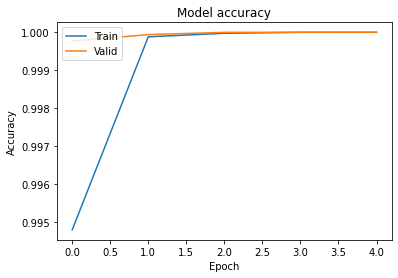

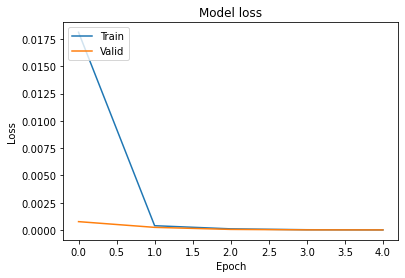

In [293]:
import matplotlib.pyplot as plt
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()    
plot_history(history)

In [294]:
val_df.head()

,display_id,uuid,document_id,timestamp,platform,geo_location,ad_id_x,clicked,doc_category,doc_cat_confidence,doc_entity,doc_ent_confidence,doc_meta_source,doc_meta_publisher,doc_topic,doc_confidence,ad_id_y,campaign_id,advertiser_id
534619,779,5c1baf33fdccfd,472838,55814,1,CA>QC,244559,0,1403,0.92,8f2e8d2a6c3bd010e72de7a24bd5f5f8,0.234009,6431.0,973.0,26,0.019912,570364,35443,1008
1637848,4795,4991c643d2df8d,472838,327771,1,AU>02,209223,0,1403,0.92,fddde555242d42f4de6e5ec05c0ec691,0.246240,6431.0,973.0,249,0.148749,292256,28156,1008
624139,779,5c1baf33fdccfd,472838,55814,1,CA>QC,252928,0,1403,0.92,2644657576cef207a34ac9620f6aefb1,0.232867,6431.0,973.0,26,0.019912,570260,35440,1008
1779421,4795,4991c643d2df8d,472838,327771,1,AU>02,252928,0,1602,0.07,4f888e884e41a682ce2ebfa98dac88a1,0.228164,6431.0,973.0,16,0.045601,386617,30455,1008
739365,779,5c1baf33fdccfd,472838,55814,1,CA>QC,288355,0,1602,0.07,d7fb311e5ae6cbd6888d798b5374fa80,0.256552,6431.0,973.0,26,0.019912,570278,35439,1008


In [306]:
val_df['uuid'].value_counts()

4991c643d2df8d    102447
5487685fc78476    102408
5c1baf33fdccfd    102374
7ea9d9b7415808      4277
7700539ef47f4d      4249
                   ...  
226edef651433c         1
232e392a49f110         1
829e9a4e453216         1
8c63b52303cd86         1
40f92f8b46febe         1
Name: uuid, Length: 306, dtype: int64

In [311]:
user = '7700539ef47f4d' #user_id
user_df = val_df.reset_index(drop = True).query('uuid==@user')
user_df.head()

,display_id,uuid,document_id,timestamp,platform,geo_location,ad_id_x,clicked,doc_category,doc_cat_confidence,doc_entity,doc_ent_confidence,doc_meta_source,doc_meta_publisher,doc_topic,doc_confidence,ad_id_y,campaign_id,advertiser_id
411,2825,7700539ef47f4d,1270285,195602,1,US>CA>803,87021,0,1405,0.759791,a4f1053477c28c4b393fa75f99c4017d,0.188692,766.0,495.0,47,0.009331,393077,30015,865
422,2825,7700539ef47f4d,1270285,195602,1,US>CA>803,46160,0,1510,0.057810,aa6c1ad9fe34f2ff542bc87152a7c37b,0.013703,766.0,495.0,107,0.008871,369966,30013,865
473,2825,7700539ef47f4d,1270285,195602,1,US>CA>803,87021,0,1510,0.057810,3d16b3356ba884ea31460c46d5d8c948,0.018711,766.0,495.0,258,0.230779,296099,28307,865
523,2825,7700539ef47f4d,1270285,195602,1,US>CA>803,183675,0,1405,0.759791,a4f1053477c28c4b393fa75f99c4017d,0.188692,766.0,495.0,258,0.230779,319377,28973,865
537,2825,7700539ef47f4d,1270285,195602,1,US>CA>803,57069,1,1405,0.759791,aa6c1ad9fe34f2ff542bc87152a7c37b,0.013703,766.0,495.0,258,0.230779,371506,30030,865


In [312]:
user_df.index

Int64Index([   411,    422,    473,    523,    537,    656,    770,    789,
               798,    818,
            ...
            384516, 384769, 384822, 385310, 385351, 385409, 385519, 385609,
            385793, 385802],
           dtype='int64', length=4249)

In [313]:
user_inputs = [pp.transform(val_df)[user_df.index, i] for i in range(feature_num)]
user_df['pred'] = model.predict(user_inputs)
user_df = user_df.sort_values('pred', ascending=False)

133/133 [==============================] - 0s 2ms/step


In [315]:
user_df[['display_id', 'ad_id_x', 'pred']].tail(50)

,display_id,ad_id_x,pred
246838,2825,46160,8.096556e-14
375610,2825,46160,8.073240e-14
14204,2825,46160,8.049944e-14
363383,2825,46160,7.999893e-14
373138,2825,46160,7.999893e-14
194715,2825,46160,7.999039e-14
348766,2825,46160,7.963493e-14
16748,2825,46160,7.880961e-14
348254,2825,46160,7.880961e-14
289579,2825,46160,7.880961e-14
